<a href="https://colab.research.google.com/github/cdrc1103/DL_Project13e/blob/main/Rejsekort_to_Sensor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import itertools
from torch.utils.data import Dataset, DataLoader
import random
import os

In [2]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')
import drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Experimenting with bus demand data from November 1st, 2020

In this section we explore the data available in *apc-afc-matched* tables by visualising the demand for bus line 150 on a single journey on November 1st, 2020 (a random example from the dataset).

In [3]:
# read Rejsekort-sensor matched data from November, 2020
# note: adjust the path to match yours
md = pd.read_csv("drive/MyDrive/deep_proj/Project/Data/sensor_data/11/apc-afc-matched-20201101.csv")

In [4]:
# show the table (with columns reordered for convenience)
cols_to_order = ['JourneyRef', 'Time', 'LineNumber', 'LineDirectionCode', 'StopPointId', 'JourneyPointRef', 'UpstreamTimingPointAbbreviation', 'DownstreamTimingPointAbbreviation','AfcBoardingCount', 'AfcAlightingCount', 'ApcBoardingCount', 'ApcAlightingCount']
md = md[cols_to_order]
md['Time'] = pd.to_datetime(md['Time'])
md

,JourneyRef,Time,LineNumber,LineDirectionCode,StopPointId,JourneyPointRef,UpstreamTimingPointAbbreviation,DownstreamTimingPointAbbreviation,AfcBoardingCount,AfcAlightingCount,ApcBoardingCount,ApcAlightingCount
0,20201101L0001J0023,2020-11-01 11:15:11,1,1,28399,20201101L0001J0023#001,AVST,AVST,0,0,1,0
1,20201101L0001J0023,2020-11-01 11:17:14,1,1,6916,20201101L0001J0023#002,AVST,REBS,0,0,0,0
2,20201101L0001J0023,2020-11-01 11:18:15,1,1,6917,20201101L0001J0023#003,AVST,REBS,0,0,0,0
3,20201101L0001J0023,2020-11-01 11:18:54,1,1,6918,20201101L0001J0023#004,REBS,REBS,0,0,1,0
4,20201101L0001J0023,2020-11-01 11:20:17,1,1,10847,20201101L0001J0023#005,REBS,HVHO,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
31766,20201101L0908J0064,2020-11-01 18:25:49,908,2,43052,20201101L0908J0064#017,BIRKE,MOTVE,0,0,0,0
31767,20201101L0908J0064,2020-11-01 18:26:40,908,2,43042,20201101L0908J0064#018,MOTVE,MOTVE,0,0,0,0
31768,20201101L0908J0064,2020-11-01 18:27:28,908,2,43039,20201101L0908J0064#019,MOTVE,KORST,0,0,0,0
31769,20201101L0908J0064,2020-11-01 18:28:21,908,2,38533,20201101L0908J0064#020,MOTVE,KORST,0,0,0,0


In [5]:
# show only the rows for bus line 150 and a specific random journey in one direction
journey = md[(md.LineNumber == 150) & (md.JourneyRef == '20201101L0150J0013') & (md.LineDirectionCode == 1)]
journey

,JourneyRef,Time,LineNumber,LineDirectionCode,StopPointId,JourneyPointRef,UpstreamTimingPointAbbreviation,DownstreamTimingPointAbbreviation,AfcBoardingCount,AfcAlightingCount,ApcBoardingCount,ApcAlightingCount
13577,20201101L0150J0013,2020-11-01 01:32:16,150,1,6231,20201101L0150J0013#001,KDST,KDST,0,0,1,0
13578,20201101L0150J0013,2020-11-01 01:34:19,150,1,28183,20201101L0150J0013#003,KDST,EGEV,0,0,0,0
13579,20201101L0150J0013,2020-11-01 01:37:01,150,1,6001,20201101L0150J0013#006,KDST,EGEV,0,0,2,1
13580,20201101L0150J0013,2020-11-01 01:39:30,150,1,6137,20201101L0150J0013#009,EGEV,EGEV,2,0,0,0
13581,20201101L0150J0013,2020-11-01 01:40:52,150,1,6003,20201101L0150J0013#010,EGEV,HHLS,0,0,0,0
13582,20201101L0150J0013,2020-11-01 01:41:34,150,1,6004,20201101L0150J0013#011,EGEV,HHLS,0,0,0,0
13583,20201101L0150J0013,2020-11-01 01:42:22,150,1,6005,20201101L0150J0013#012,HHLS,HHLS,0,0,0,0
13584,20201101L0150J0013,2020-11-01 01:43:32,150,1,6006,20201101L0150J0013#013,HHLS,HHM,3,0,0,0
13585,20201101L0150J0013,2020-11-01 01:44:53,150,1,6007,20201101L0150J0013#014,HHM,HHM,0,2,1,0
13586,20201101L0150J0013,2020-11-01 01:46:11,150,1,6008,20201101L0150J0013#015,HHM,GLHO,0,0,0,0


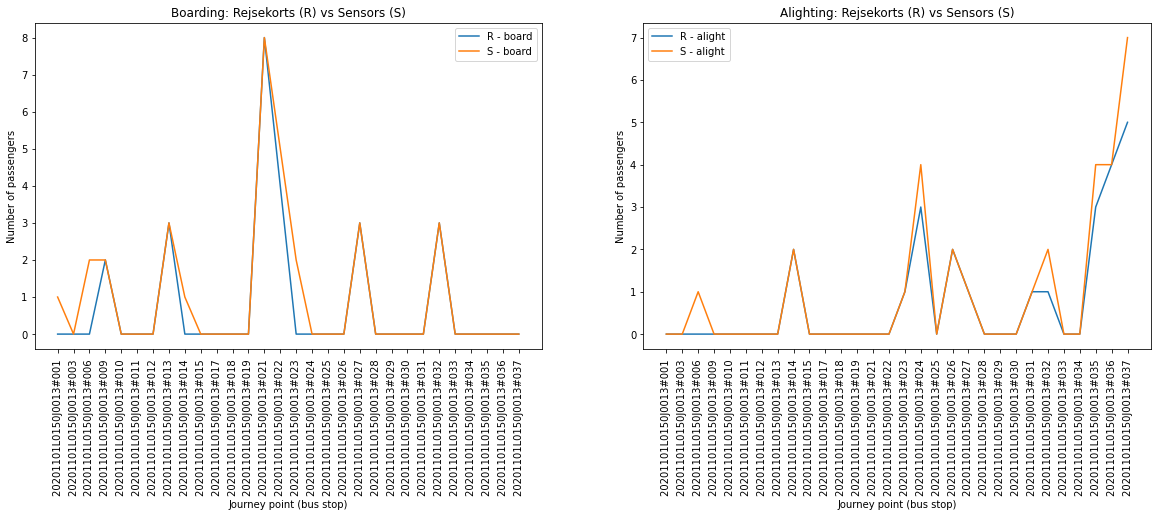

In [6]:
# visualise boarding and alighting counts during the journey
x = journey["JourneyPointRef"]
y_RB = journey["AfcBoardingCount"]
y_RA = journey["AfcAlightingCount"]

y_SB = journey["ApcBoardingCount"] + journey["AfcBoardingCount"]
y_SA = journey["ApcAlightingCount"] + journey["AfcAlightingCount"]

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))
ax1.plot(x, y_RB, label="R - board")
ax1.plot(x, y_SB, label="S - board")
ax1.set_xticklabels(x, rotation=90)
ax1.set_xlabel("Journey point (bus stop)")
ax1.set_ylabel("Number of passengers")
ax1.legend()
ax1.set_title("Boarding: Rejsekorts (R) vs Sensors (S)")

ax2.plot(x, y_RA, label="R - alight")
ax2.plot(x, y_SA, label="S - alight")
ax2.set_xticklabels(x, rotation=90)
ax2.set_xlabel("Journey point (bus stop)")
ax2.set_ylabel("Number of passengers")
ax2.legend()
ax2.set_title("Alighting: Rejsekorts (R) vs Sensors (S)")

plt.show()

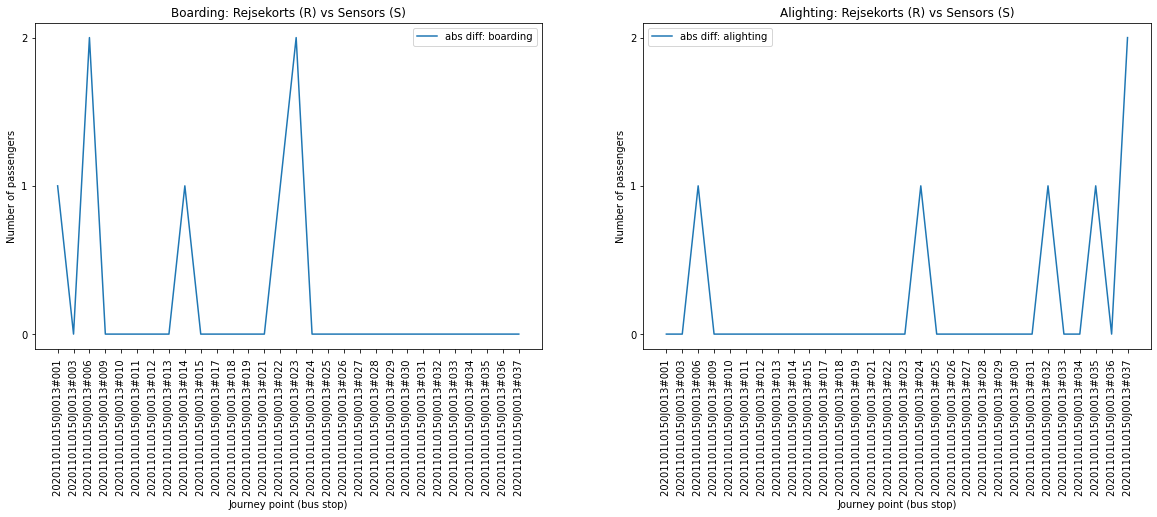

In [7]:
# visualise the absolute difference between passengers travelling with and without Rejsekort
x = journey["JourneyPointRef"]
y_RB = journey["AfcBoardingCount"]
y_RA = journey["AfcAlightingCount"]

y_SB = journey["ApcBoardingCount"] + journey["AfcBoardingCount"]
y_SA = journey["ApcAlightingCount"] + journey["AfcAlightingCount"]

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))
ax1.plot(x, y_SB - y_RB, label="abs diff: boarding")
ax1.set_xticklabels(x, rotation=90)
ax1.yaxis.get_major_locator().set_params(integer=True)
ax1.set_xlabel("Journey point (bus stop)")
ax1.set_ylabel("Number of passengers")
ax1.legend()
ax1.set_title("Boarding: Rejsekorts (R) vs Sensors (S)")

ax2.plot(x, y_SA - y_RA, label="abs diff: alighting")
ax2.set_xticklabels(x, rotation=90)
ax2.yaxis.get_major_locator().set_params(integer=True)
ax2.set_xlabel("Journey point (bus stop)")
ax2.set_ylabel("Number of passengers")
ax2.legend()
ax2.set_title("Alighting: Rejsekorts (R) vs Sensors (S)")

plt.show()

Next, we reduce the dataset size by grouping the demand at each single bus stop into the demand at timing points. In short, if a passenger enters a bus at a stop between two timing points, such a passenger is considered to board the bus at the timing point preceeding that stop/ The number of passengers alighting is calculated in a similar fashion.

In [8]:
# group the numbers at each bus stop in the number at each timing point for the single journey selected
tp_b = journey.groupby(["UpstreamTimingPointAbbreviation"], sort=False)[["AfcBoardingCount", "ApcBoardingCount"]].sum().reset_index()
tp_a = journey.groupby(["DownstreamTimingPointAbbreviation"], sort=False)[["AfcAlightingCount", "ApcAlightingCount"]].sum().reset_index()

tp_b.rename({"UpstreamTimingPointAbbreviation": "TimingPoint"}, axis=1, inplace=True)
tp_a.rename({"DownstreamTimingPointAbbreviation": "TimingPoint"}, axis=1, inplace=True)

tp = tp_b.merge(tp_a)
tp.reset_index()
tp

,TimingPoint,AfcBoardingCount,ApcBoardingCount,AfcAlightingCount,ApcAlightingCount
0,KDST,0,3,0,0
1,EGEV,2,0,0,1
2,HHLS,3,0,0,0
3,HHM,0,1,2,0
4,GLHO,8,0,0,0
5,NÆST,4,3,0,0
6,KLBV,3,0,4,1
7,RYST,0,0,3,0
8,HKP,3,0,0,0
9,NPST1,0,0,14,4


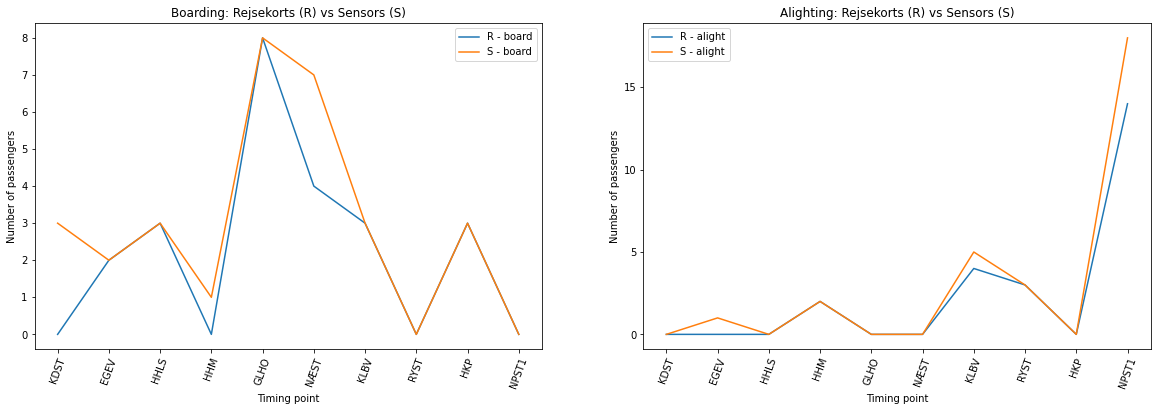

In [9]:
# visualise the grouped demand
x = tp["TimingPoint"]
y_RB = tp["AfcBoardingCount"]
y_RA = tp["AfcAlightingCount"]

y_SB = tp["ApcBoardingCount"] + tp["AfcBoardingCount"]
y_SA = tp["ApcAlightingCount"] + tp["AfcAlightingCount"]

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))
ax1.plot(x, y_RB, label="R - board")
ax1.plot(x, y_SB, label="S - board")
ax1.set_xticklabels(x, rotation=70)
ax1.set_ylabel("Number of passengers")
ax1.set_xlabel("Timing point")
ax1.yaxis.get_major_locator().set_params(integer=True)
ax1.legend()
ax1.set_title("Boarding: Rejsekorts (R) vs Sensors (S)")

ax2.plot(x, y_RA, label="R - alight")
ax2.plot(x, y_SA, label="S - alight")
ax2.set_xticklabels(x, rotation=70)
ax2.yaxis.get_major_locator().set_params(integer=True)
ax2.set_ylabel("Number of passengers")
ax2.set_xlabel("Timing point")
ax2.legend()
ax2.set_title("Alighting: Rejsekorts (R) vs Sensors (S)")

plt.show()

We work with crowdedness in the intervals between two timing points in our main model, so we process the Rejsekort and sensor data to calculate the number of passengers between two timing points (i.e. in an interval). Also, we create two additional features: *time of the day* and *day of the week* for each data sample (journey). As the sensor data available for bus line 150 in a single direction is scarce (only several hundred samples in the 4 months from August to November), we have to reduce the number of possible values those features can acquire. Thus, we split the day into 4 parts: morning, afternoon, evening and night. The week is split into two parts: weekday (Monday - Friday) and weekend (Saturday and Sunday). The demand observed in those groups/parts shows similar trends, so such split does not lead to significant loss of information for our model.

In [10]:
# extract only route 150 in 1 direction
route150 = md[(md.LineNumber == 150) & (md.LineDirectionCode == 1)]
route150.reset_index(inplace=True)
route150 = route150.drop(["StopPointId", "LineNumber"], axis=1)

# convert time of the day (hour from 0 to 23) to a number between 0 and 1
def day_time(time):
  # morning
  if 5 <= time <= 11:
    return 0
  # afternoon
  elif 11 < time <= 15:
    return 0.33
  # evening
  elif 15 < time <= 22:
    return 0.66
  # night
  else:
    return 1

# convert day of the week (day number from 0 to 6) to either 0 or 1. 0 is returned in case the day is a weekday and 1 in case it's Saturday or Sunday 
def day_week(day):
  # weekday
  if 0 <= day <= 4:
    return 0
  # Saturday or Sunday (weekend)
  else:
    return 1

# process the data
def get_intervals_row(group):
  # extract hour and day of week. Although such an approach is not ideal, we take the time and day of the first timing point on the route
  time = day_time(group["Time"].iloc[0].hour)
  day = day_week(group["Time"].iloc[0].dayofweek)

  # merge passenger numbers at each bus stop into the numbers at timing points
  tp_b = group.groupby(["UpstreamTimingPointAbbreviation"], sort=False)[["AfcBoardingCount", "ApcBoardingCount"]].sum().reset_index()
  tp_a = group.groupby(["DownstreamTimingPointAbbreviation"], sort=False)[["AfcAlightingCount", "ApcAlightingCount"]].sum().reset_index()

  # rename columns
  tp_b.rename({"UpstreamTimingPointAbbreviation": "TimingPoint"}, axis=1, inplace=True)
  tp_a.rename({"DownstreamTimingPointAbbreviation": "TimingPoint"}, axis=1, inplace=True)

  # merge boarding and alighting data
  tp = tp_b.merge(tp_a)
  tp.reset_index()

  crowdedness_r = []
  crowdedness_s = []

  # calculate the number of people on the bus in each of the 9 intervals
  on_board_r = 0
  on_board_s = 0
  for index, row in tp.iterrows():
    on_board_r = on_board_r + row["AfcBoardingCount"] - row["AfcAlightingCount"]
    on_board_s = on_board_s + row["ApcBoardingCount"] - row["ApcAlightingCount"] + row["AfcBoardingCount"] - row["AfcAlightingCount"]

    crowdedness_r.append(on_board_r)
    crowdedness_s.append(on_board_s)

  crowdedness_r.pop() # remove last 0-entry
  crowdedness_s.pop() # remove last 0-entry

  # each row is [crowdedness in the 9 intervals based on Rejsekort data, time of the day, day of the week, crowdedness in the 9 intervals based on sensor data]
  return pd.Series(crowdedness_r + [time, day] + crowdedness_s)
 
route_150_prep = route150.groupby(["JourneyRef"], sort=False).filter(lambda g: len(g["UpstreamTimingPointAbbreviation"].unique()) == 10).groupby(["JourneyRef"], sort=False).apply(get_intervals_row)
route_150_prep

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
JourneyRef,,,,,,,,,,,,,,,,,,,,
20201101L0150J0013,0.0,2.0,5.0,3.0,11.0,15.0,14.0,11.0,14.0,1.00,1.0,3.0,4.0,7.0,6.0,14.0,21.0,19.0,16.0,19.0
20201101L0150J0049,1.0,1.0,1.0,1.0,1.0,3.0,8.0,6.0,8.0,0.66,1.0,5.0,5.0,6.0,5.0,7.0,16.0,31.0,26.0,36.0
20201101L0150J0056,0.0,0.0,0.0,1.0,3.0,4.0,7.0,7.0,10.0,0.66,1.0,1.0,1.0,2.0,6.0,10.0,12.0,22.0,22.0,30.0


# Working with the whole dataset and predicting the demand

In this section we work with the numbers of passengers boarding and alighting buses on the line 150 in one direction (from KDST to NPST1) in the months of August to November. The data for multiple journeys is processed in a similar way to the one presented in the previous section for a single bus journey. The approach below is scalable to multiple bus lines (with journeys in both directions).

In [11]:
# features
xs = None
# labels (demand)
labels = None
first = True

cols_to_order = ['JourneyRef', 'Time', 'LineNumber', 'LineDirectionCode', 'StopPointId', 'JourneyPointRef', 'UpstreamTimingPointAbbreviation', 'DownstreamTimingPointAbbreviation','AfcBoardingCount', 'AfcAlightingCount', 'ApcBoardingCount', 'ApcAlightingCount']
# each folder contains the matched data from a single month (folder '08' contains data from August etc.)
folders = ['08', '09', '10', '11']

# read the data from the 4-months period from August to November
for folder in folders:
  # read tables for each day in the month
  for file in os.listdir("drive/MyDrive/deep_proj/Project/Data/sensor_data/" + folder):
    df = pd.read_csv("drive/MyDrive/deep_proj/Project/Data/sensor_data/" + folder + "/" + file)
    
    # reorder columns
    df = df[cols_to_order]
    df['Time'] = pd.to_datetime(df['Time'])

    # select line 150 and the chosen direction 
    df = df[(df.LineNumber == 150) & (df.LineDirectionCode == 1)]
    df.reset_index(inplace=True)

    # drop unnecessary columns
    df = df.drop(["StopPointId", "LineNumber", 'LineDirectionCode'], axis=1)

    # group the bus stops into intervals between timing points and add time of the day and day of the week features 
    df = df.groupby(["JourneyRef"], sort=False).filter(lambda g: len(g["UpstreamTimingPointAbbreviation"].unique()) == 10).groupby(["JourneyRef"], sort=False).apply(get_intervals_row)
    
    # split the data into Rejsekort data (9 intervals and two time-related features) and labels with sensor counts
    if first:
      xs = df.iloc[:, 0:11]
      labels = df.iloc[:, 11:]
      first = False
    else:
      xs = xs.append(df.iloc[:, 0:11], ignore_index=True)
      labels = labels.append(df.iloc[:, 11::], ignore_index=True)

In [12]:
# create tensors
xs = torch.tensor(xs.values, dtype=torch.float)
labels = torch.tensor(labels.values, dtype=torch.float)
xs

tensor([[ 1.0000,  1.0000,  3.0000,  ...,  9.0000,  0.0000,  1.0000],
        [ 1.0000,  2.0000,  2.0000,  ..., 18.0000,  0.0000,  1.0000],
        [ 2.0000,  2.0000,  2.0000,  ..., 20.0000,  0.3300,  1.0000],
        ...,
        [ 0.0000,  2.0000,  5.0000,  ..., 14.0000,  1.0000,  1.0000],
        [ 1.0000,  1.0000,  1.0000,  ...,  8.0000,  0.6600,  1.0000],
        [ 0.0000,  0.0000,  0.0000,  ..., 10.0000,  0.6600,  1.0000]])

Next, we define a model for predicting the total number of passengers travelling on a bus from the number of people who used Rejsekort to board/alight that bus.

In [13]:
class Total(nn.Module):
    def __init__(self):
        super(Total, self).__init__()
        
        # three linear layers
        self.fc1 = nn.Linear(11, 40)  
        self.fc2 = nn.Linear(40, 30)
        self.fc3 = nn.Linear(30, 9)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Total()
print(net)

Total(
  (fc1): Linear(in_features=11, out_features=40, bias=True)
  (fc2): Linear(in_features=40, out_features=30, bias=True)
  (fc3): Linear(in_features=30, out_features=9, bias=True)
)


In [14]:
# sample outputs to see if the model works
outputs = net(xs)
outputs

tensor([[ 0.5327,  0.2512, -0.5986,  ...,  0.6589, -1.7216, -0.9430],
        [ 0.9250, -0.2795, -1.0601,  ...,  0.9774, -2.5594, -1.8418],
        [ 1.0112, -0.2605, -1.4899,  ...,  1.2873, -3.6651, -2.4094],
        ...,
        [ 0.7559,  0.5241, -0.7298,  ...,  0.5937, -2.3881, -1.2559],
        [ 0.2437, -0.4260, -0.3681,  ...,  0.4041, -0.9450, -0.9060],
        [ 0.3345, -0.5194, -0.4615,  ...,  0.4542, -0.9919, -1.0538]],
       grad_fn=<AddmmBackward>)

In [15]:
# combine features and labels into the dataset
dataset = np.hstack((xs, labels))
dataset.shape

(543, 20)

As we only have little data available for each single bus line in each direction, the model can end up being untrained on certain combinations of *time of the day* and *day of the week* features and perform poorly if the training samples are badly selected. Thus, we apply stratified sampling to try to select samples from rows with every combination of *time of the day* and *day of the week* features to our training data. 

In [21]:
# stratified sampling
train_idx, val_idx, test_idx = [], [], []
dataset_s = dataset[np.lexsort((dataset[:, 1], dataset[:, 0]))]

k = 0 
# for each combination of time of the day and day of the week select some samples to the training dataset
for i in range(4):
  for j in range(7):
    df = dataset_s[(dataset_s[:, 0] == i) & (dataset_s[:, 1] == j)]
    
    n = len(df)

    n_test = max(int(n * 0.1), 1)
    n_train = n - 2 * n_test

    idx = list(range(k, n + k)) 
    random.shuffle(idx) 

    train_idx += idx[:n_train]
    val_idx += idx[n_train:(n_train + n_test)]
    test_idx += idx[(n_train + n_test):]
    
    k += n

# create tensors
train_set = torch.tensor(dataset[train_idx], dtype=torch.float)
val_set = torch.tensor(dataset[val_idx], dtype=torch.float)
test_set = torch.tensor(dataset[test_idx], dtype=torch.float)

In [22]:
# size of the test set
test_set.shape

torch.Size([46, 20])

Then, we train the model.

Epoch 0: train loss: 8563.414077758789, validation loss: 35942.15784454346
Epoch 10: train loss: 1204.501657485962, validation loss: 1714.6274106502533
Epoch 20: train loss: 938.8678379058838, validation loss: 1527.6308879852295
Epoch 30: train loss: 1025.2555360794067, validation loss: 1929.7024995088577
Epoch 40: train loss: 960.2218647003174, validation loss: 1845.1221112012863
Epoch 50: train loss: 922.1231937408447, validation loss: 1685.7970869541168
Epoch 60: train loss: 967.7891693115234, validation loss: 1963.772128611803
Epoch 70: train loss: 957.6875162124634, validation loss: 1795.15698030591
Epoch 80: train loss: 1022.9288806915283, validation loss: 1783.8744413852692
Epoch 90: train loss: 849.6712522506714, validation loss: 1754.4499357789755
Epoch 99: train loss: 825.3532123565674, validation loss: 1809.1576595306396


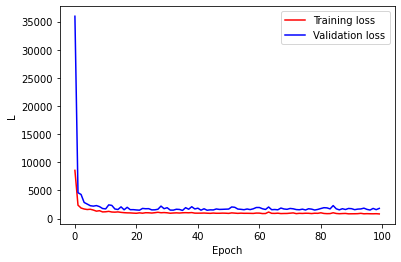

In [23]:
num_epochs = 100
batch_size = 12

net = Total()

criterion = nn.MSELoss() 
optimizer = optim.Adam(net.parameters(), lr=0.01) 

training_loss, validation_loss = [], []

for epoch in range(num_epochs):
    epoch_training_loss = 0
    epoch_validation_loss = 0
    
    net.eval()
    for i in range(val_set.size()[0]):
        # print(val_set[0][:11])
        outputs = net(val_set[i][:11])
        
        loss = criterion(outputs, val_set[i][11:])
        epoch_validation_loss += loss.item()

    net.train()
    permutation = torch.randperm(train_set.size()[0])

    for i in range(0, train_set.size()[0], batch_size):
        optimizer.zero_grad()

        indices = permutation[i:i + batch_size]
        batch_x, batch_y = train_set[indices][:, :11], train_set[indices][:, 11:]

        outputs = net.forward(batch_x)
        loss = criterion(outputs, batch_y)

        loss.backward()
        optimizer.step()

        epoch_training_loss += loss.item()
    
    if epoch % 10 == 0 or epoch == (num_epochs - 1):
      print('Epoch {}: train loss: {}, validation loss: {}'.format(epoch, epoch_training_loss, epoch_validation_loss))

    training_loss.append(epoch_training_loss)
    validation_loss.append(epoch_validation_loss)


# plot the loss
ep = np.arange(len(training_loss))
plt.figure()
plt.plot(ep, training_loss, 'r', label='Training loss',)
plt.plot(ep, validation_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('L')
plt.show()

Testing the model:

Test Loss:  3234.4562125205994


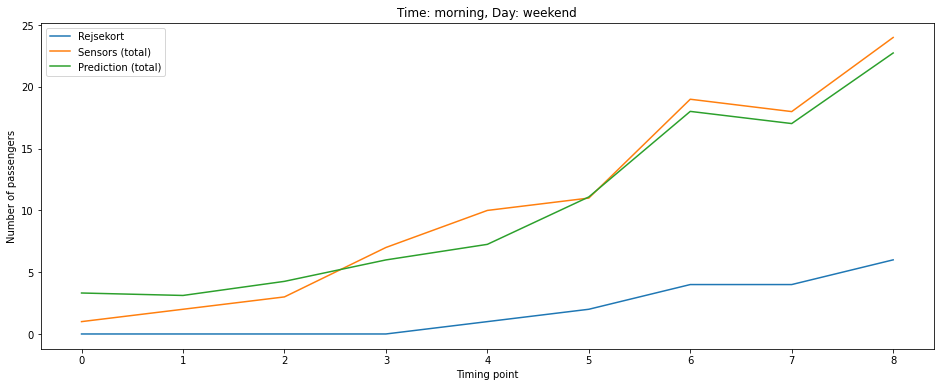

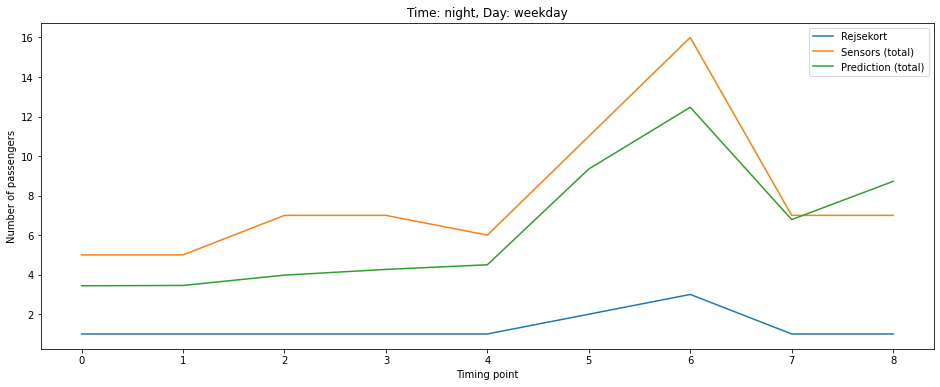

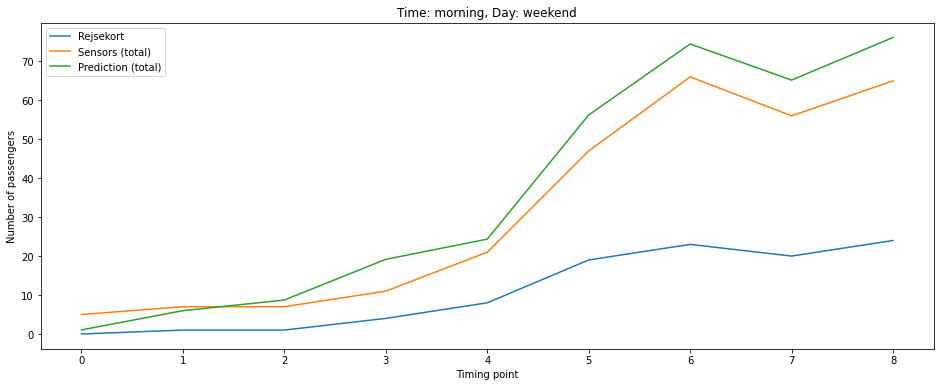

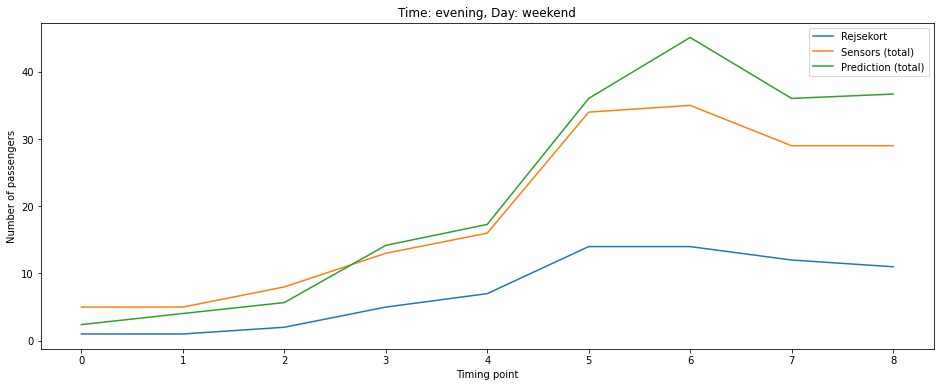

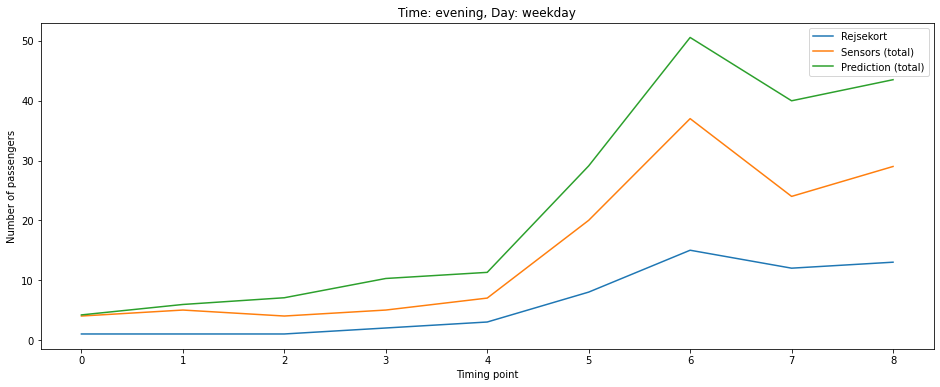

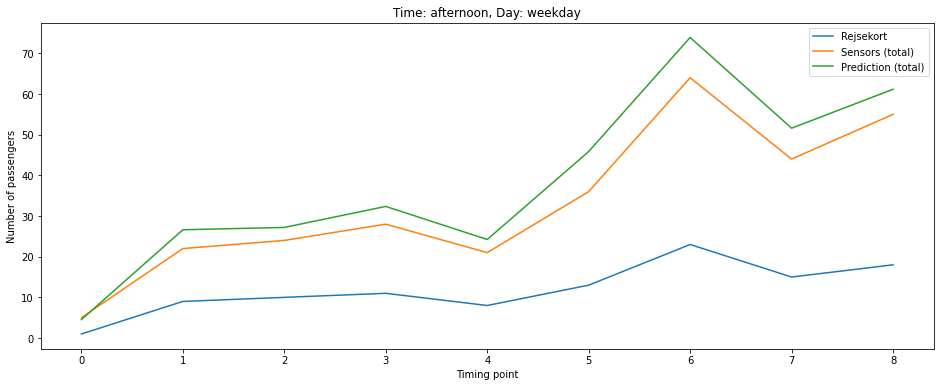

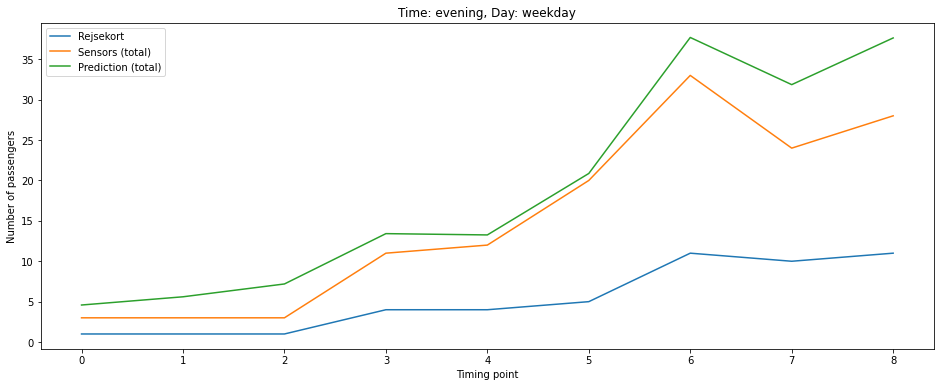

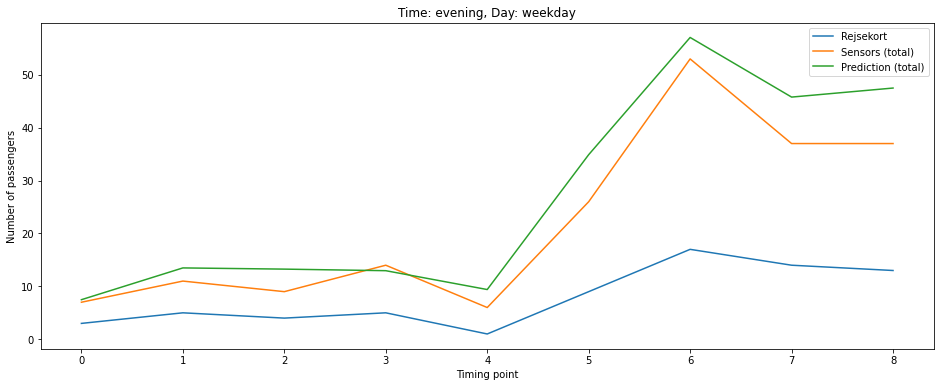

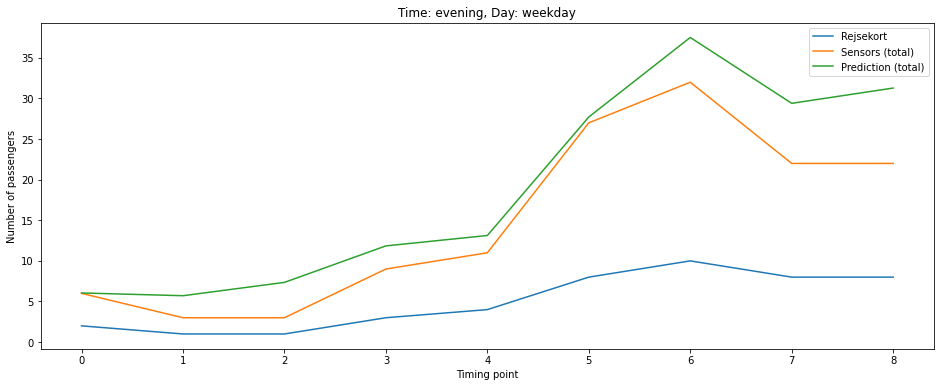

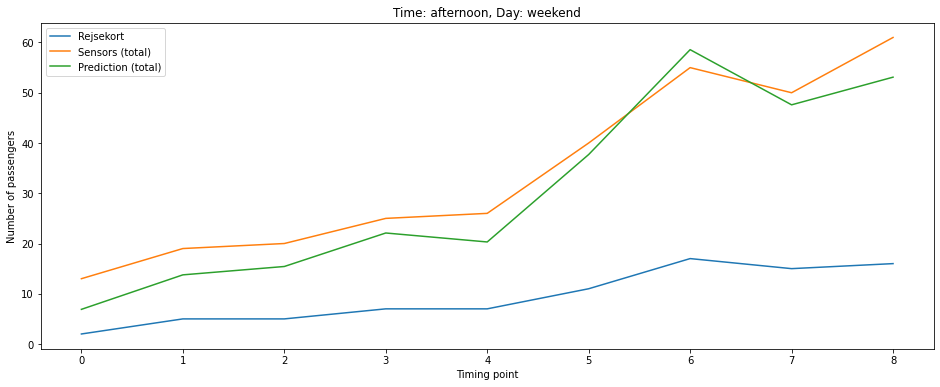

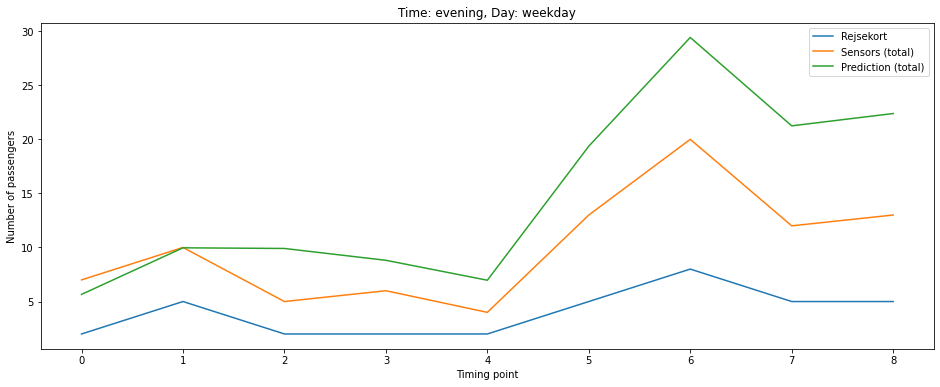

In [31]:
# test the model on the test set

convert_time = {
    0 : 'morning',
    3 : 'afternoon',
    6 : 'evening',
    10: 'night'
}

convert_day = {
    0 : 'weekday',
    1: 'weekend'
}

test_loss = 0

net.eval()
ep = 0

for i in range(test_set.size()[0]):
  ep += 1
  outputs = net(test_set[i][:11])
  loss = criterion(outputs, test_set[i][11:])

  # Update loss
  test_loss += loss.item()

  # plot some of the predictions
  if ep % 4 == 0:
    plt.figure(figsize=(16,6))
    plt.title("Time: " + str(convert_time[int(test_set[i].numpy()[9] * 10)]) + ", Day: " + str(convert_day[int(test_set[i].numpy()[10])]))
    plt.plot(range(9), test_set[i][0:9], label="Rejsekort")
    plt.plot(range(9), test_set[i][11:], label="Sensors (total)")
    plt.plot(range(9), outputs.detach(), label="Prediction (total)")
    # plt.yaxis.get_major_locator().set_params(integer=True)
    plt.ylabel("Number of passengers")
    plt.xlabel("Timing point")
    plt.legend()
    
print("Test Loss: ", (test_loss))

We save the model to use it in our main Seq2Seq model.

In [32]:
torch.save(net.state_dict(), "drive/MyDrive/deep_proj/Project/rejsekort_to_sensor.pt")